<a href="https://colab.research.google.com/github/paditya09/colab/blob/master/Uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Upload

In [0]:
import io
import pandas as pd
import numpy as np

# Upload CSV file
from google.colab import files
uploaded = files.upload()


Saving trips_data.csv to trips_data.csv


# Data Parsing

In [0]:
# Uber ride datetime strings are stored with full timezone information
# Example: 2019-08-29 01:03:26 +0000 UTC
date_parser = lambda date_string: pd.datetime.strptime(
    date_string, '%Y-%m-%d %H:%M:%S %z %Z')

ride_data = pd.read_csv(
    io.BytesIO(uploaded['trips_data.csv']),
    parse_dates=['Request Time', 'Begin Trip Time', 'Dropoff Time'],
    date_parser=date_parser,
    dtype={'Fare Amount': 'float'}
)

# Small check that the uploaded CSV file meets my expectations
if (ride_data.columns.to_list() != [
        'City', 'Product Type', 'Trip or Order Status', 'Request Time',
       'Begin Trip Time', 'Begin Trip Lat', 'Begin Trip Lng',
       'Begin Trip Address', 'Dropoff Time', 'Dropoff Lat', 'Dropoff Lng',
       'Dropoff Address', 'Distance (miles)', 'Fare Amount', 'Fare Currency']):
  raise Exception(
      "CSV file doesn't have expected column names: %s" % ride_data.columns.to_list)

# Now the cleanup begins
ride_data = ride_data.replace('uberX', 'UberX')
ride_data = ride_data.replace(regex=r'.*(BLACK|black|Black).*', value='UberBlack')

ride_data = ride_data.replace('sf bay area', 'UberBlack')
#df2 = df2.replace('San Francisco', 'UberBlack')
ride_data = ride_data.replace(regex=r'.*EATS.*', value='UberEATS')
ride_data = ride_data.replace(regex=r'.*EXPRESS.*', value='Express Pool')
ride_data = ride_data.replace(regex=r'.*Express.*', value='Express Pool')
ride_data = ride_data.replace(regex=r'.*POOL.*', value='Uber Pool')
ride_data = ride_data.replace(regex=r'.*UberPool.*', value='Uber Pool')
ride_data = ride_data.replace(regex=r'^Pool:.*', value='Uber Pool')

# Derived Columns

In [0]:
exchange_rates = {
    'USD': 1,
    'EUR': 1.11,
    'INR': 0.014,
    'CAD': 0.75,
    'CHF': 1.01,
    'GBP': 1.22,
    'CZK': 0.043
}

ride_data['USD Amount'] = ride_data.apply(
    lambda row: row['Fare Amount'] * exchange_rates[row['Fare Currency']],
    axis=1)

# Need a helper function to avoid dividing by zero for rides that didn't happen
# and therefore have a fare of $0.
def dollarPerMiles(fare, miles):
  if miles:
    return fare / miles
  else:
    0

ride_data['Cost per Mile'] = ride_data.apply(
    lambda row: dollarPerMiles(row['USD Amount'], row['Distance (miles)']),
    axis=1)

ride_data['Trip Duration'] = ride_data.apply(
    lambda row: row['Dropoff Time'] - row['Begin Trip Time'], axis=1)


# Helper Functions

In [0]:
# Creates a bar chart for the given data with the given x-axis label and y-axis
# label.
def create_bar(data, xlabel, ylabel):
  ax = data.plot.bar(figsize=(15,5))
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  def add_labels(ax, data):
    rects = ax.patches

    for rect, label in zip(rects, data):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
                ha='center', va='bottom')

  add_labels(ax, data)

# For time series over the years, I need annually grouped numbers for requested
# and completed rides later on.
annual_requested_rides = ride_data.groupby(
    ride_data['Request Time'].dt.year)

completed_rides = ride_data[ride_data['Trip or Order Status'] == 'COMPLETED']

annual_completed_rides = completed_rides.groupby(
    completed_rides['Request Time'].dt.year)

# For other time series I need the data set grouped by year and product type (
# Uber Black, UberX, ...)

annual_completed_rides_p = completed_rides.groupby(
    [completed_rides['Request Time'].dt.year, 'Product Type'])

# Global Statistics

In [0]:
format_date = lambda date: date.strftime('%m/%d/%Y')
first_ride = ride_data['Request Time'].min()
last_ride = ride_data['Request Time'].max()
days_between = (last_ride - first_ride).days
years_between = days_between / 365
print("Covered timeframe: %s to %s (%s days = %.2f years)" % (
    format_date(first_ride), format_date(last_ride),
    days_between, years_between))
print()

total_rides_count = len(ride_data.index)
print("Total number of requested rides: ", total_rides_count)

completed_rides_count = len(completed_rides)
print("Total number of completed rides: ", completed_rides_count)

miles_driven = ride_data['Distance (miles)'].sum()
print("Total miles driven: %.2f" % miles_driven)

dollars_spent = ride_data['USD Amount'].sum()
print("Total amount of money spent: $%.2f" % dollars_spent)

dollars_per_mile = dollars_spent / miles_driven
print("Total cost/mile: $%.2f" % dollars_per_mile)

Covered timeframe: 10/01/2013 to 07/29/2019 (2126 days = 5.82 years)

Total number of requested rides:  83
Total number of completed rides:  75
Total miles driven: 451.50
Total amount of money spent: $1284.15
Total cost/mile: $2.84


# Cities

In [0]:
ride_data.groupby(ride_data['City']).size().sort_values(ascending=False)

City
New Jersey         37
Paris              10
Washington D.C.     9
Bangalore           5
Toronto             3
Seattle             3
San Francisco       3
Philadelphia        3
Hyderabad           3
Rome                2
New York City       2
Vienna              1
Chicago             1
Austin              1
dtype: int64

# Total trips and spending per year

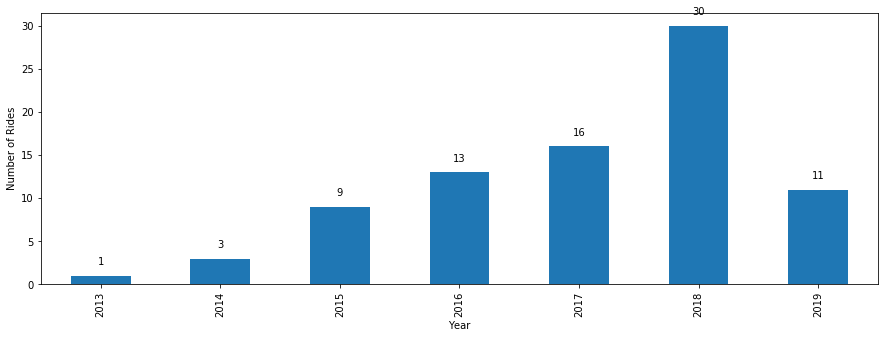

In [0]:
# Using requested rides rather than completed rides here as cancelled rides cost
# money too in the form of cancellation fees.

create_bar(annual_requested_rides.size(), 'Year', 'Number of Rides')